ALL codes to run Scrabble game. 

In [1]:
# Imported Modules
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [2]:
### This set of codes controls the scoring system in Scrabble
# Score for each letter (b for blank tile)
LETTER_POINTS = {
"A":1, "B":3, "C":3, "D":2, "E":1, "F":4, "G":2, "H":4, "I":1,
"J":8, "K":5, "L":1, "M":3, "N":1, "O":1, "P":3, "Q":10, "R":1,
"S":1, "T":1, "U":1, "V":4, "W":4, "X":8, "Y":4, "Z":10, "b":0
}

# Load real Scrabble dictionary (ENABLE)
with open("enable1.txt", "r") as f:
    VALID_WORDS = set(w.strip().upper() for w in f)

def reset_game():
    '''Resets the letter and word multiplier'''

    # Ensure they are global variables
    global letter_multiplier, word_multiplier

    # The letter bonuses
    letter_multiplier = np.array([
        [1,1,1,2,1,1,1,1,1,1,1,2,1,1,1],
        [1,1,1,1,1,3,1,1,1,3,1,1,1,1,1],
        [1,1,1,1,1,1,2,1,2,1,1,1,1,1,1],
        [2,1,1,1,1,1,1,2,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [1,3,1,1,1,3,1,1,1,3,1,1,1,3,1],
        [1,1,2,1,1,1,2,1,2,1,1,1,2,1,1],
        [1,1,1,2,1,1,1,1,1,1,1,2,1,1,1],
        [1,1,2,1,1,1,2,1,2,1,1,1,2,1,1],
        [1,3,1,1,1,3,1,1,1,3,1,1,1,3,1],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [2,1,1,1,1,1,1,2,1,1,1,1,1,1,2],
        [1,1,1,1,1,1,2,1,2,1,1,1,1,1,1],
        [1,1,1,1,1,3,1,1,1,3,1,1,1,1,1],
        [1,1,1,2,1,1,1,1,1,1,1,2,1,1,1]
    ])

    # The word bonuses
    word_multiplier = np.array([
        [3,1,1,1,1,1,1,3,1,1,1,1,1,1,3],
        [1,2,1,1,1,1,1,1,1,1,1,1,1,2,1],
        [1,1,2,1,1,1,1,1,1,1,1,1,2,1,1],
        [1,1,1,2,1,1,1,1,1,1,1,2,1,1,1],
        [1,1,1,1,2,1,1,1,1,1,2,1,1,1,1],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [3,1,1,2,1,1,1,2,1,1,1,2,1,1,3],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        [1,1,1,1,2,1,1,1,1,1,2,1,1,1,1],
        [1,1,1,2,1,1,1,1,1,1,1,2,1,1,1],
        [1,1,2,1,1,1,1,1,1,1,1,1,2,1,1],
        [1,2,1,1,1,1,1,1,1,1,1,1,1,2,1],
        [3,1,1,1,1,1,1,3,1,1,1,1,1,1,3]
    ])

def find_main_word(diff_indices, board):
    '''Finds the main word that has been added'''

    # Normalize to list of tuples
    diff = [(int(r), int(c)) for r, c in diff_indices]
    rows = [r for r, c in diff]
    cols = [c for r, c in diff]

    # Horizontal if all rows same
    if len(set(rows)) == 1:
        r = rows[0]
        start_c = min(cols)
        end_c = max(cols)
        # Expand left
        while start_c > 0 and board[r, start_c - 1] != "":
            start_c -= 1
        # Expand right
        while end_c < 14 and board[r, end_c + 1] != "":
            end_c += 1
        positions = [(r, c) for c in range(start_c, end_c + 1)]
        word = "".join(board[r, c] for (r, c) in positions)
        return word, positions

    # Vertical if all cols same
    if len(set(cols)) == 1:
        c = cols[0]
        start_r = min(rows)
        end_r = max(rows)
        # Expand up
        while start_r > 0 and board[start_r - 1, c] != "":
            start_r -= 1
        # Expand down
        while end_r < 14 and board[end_r + 1, c] != "":
            end_r += 1
        positions = [(r, c) for r in range(start_r, end_r + 1)]
        word = "".join(board[r, c] for (r, c) in positions)
        return word, positions

    # Not aligned: try to detect orientation from adjacency of the first new tile
    r0, c0 = diff[0]

    # Horizontal adjacency?
    if (c0 > 0 and board[r0, c0 - 1] != "") or (c0 < 14 and board[r0, c0 + 1] != ""):
        start_c = c0
        while start_c > 0 and board[r0, start_c - 1] != "":
            start_c -= 1
        end_c = c0
        while end_c < 14 and board[r0, end_c + 1] != "":
            end_c += 1
        positions = [(r0, c) for c in range(start_c, end_c + 1)]
        word = "".join(board[r0, c] for (r0, c) in positions)
        return word, positions

    # Vertical adjacency?
    if (r0 > 0 and board[r0 - 1, c0] != "") or (r0 < 14 and board[r0 + 1, c0] != ""):
        start_r = r0
        while start_r > 0 and board[start_r - 1, c0] != "":
            start_r -= 1
        end_r = r0
        while end_r < 14 and board[end_r + 1, c0] != "":
            end_r += 1
        positions = [(r, c0) for r in range(start_r, end_r + 1)]
        word = "".join(board[r, c0] for (r, c0) in positions)
        return word, positions

    return board[r0, c0], [(r0, c0)]

def find_all_words(diff_indices, board):
    '''Return a list of (word, positions) for all words formed this turn.'''
    words = []
    main_word, main_pos = find_main_word(diff_indices, board)
    if main_word:
        words.append((main_word, main_pos))

    diff_set = set(diff_indices)
    for r, c in diff_indices:
        # Check perpendicular direction
        if all(pos[0] == r for pos in main_pos):
            # Main word is horizontal → check vertical word
            start_r = r
            while start_r > 0 and board[start_r-1, c] != "":
                start_r -= 1
            end_r = r
            while end_r < 14 and board[end_r+1, c] != "":
                end_r += 1

            # There is a vertical word
            if end_r != start_r: 
                positions = [(rr, c) for rr in range(start_r, end_r+1)]
                word = "".join(board[rr, c] for rr in range(start_r, end_r+1))
                if (word, positions) not in words:
                    words.append((word, positions))
        else:
            # Main word is vertical → check horizontal word
            start_c = c
            while start_c > 0 and board[r, start_c-1] != "":
                start_c -= 1
            end_c = c
            while end_c < 14 and board[r, end_c+1] != "":
                end_c += 1

            # There is a horizontal word
            if end_c != start_c:  
                positions = [(r, cc) for cc in range(start_c, end_c+1)]
                word = "".join(board[r, cc] for cc in range(start_c, end_c+1))
                if (word, positions) not in words:
                    words.append((word, positions))

    return words

def is_word_real(all_words):
    '''Checks all words to ensure they are real'''

    for word, positions in all_words:
        # Skip validation if the word contains a blank tile (trust player)
        if "b" in word:
            continue

        # Check validity against the word list
        if word not in VALID_WORDS:
            print(f"'{word}' is not a valid word!")

    return

def calculate_score(all_words, diff_indices, current_board):
    '''Calculates the score from the words in this turn'''

    # Extracting the words
    diff_set = set((int(r), int(c)) for r, c in diff_indices)

    # Finding the score of each word
    score = 0
    for word, positions in all_words:
        word_mult = []
        word_score = 0
        for r, c in positions:
            letter = current_board[r, c]
            base_points = LETTER_POINTS.get(letter, 0)
            if (r, c) in diff_set:
                base_points *= letter_multiplier[r, c]
                word_mult.append(word_multiplier[r, c])
            word_score += base_points
        score += word_score*max(word_mult)

    # Reset multipliers for the squares used in this turn
    for r, c in diff_set:
        letter_multiplier[r, c] = 1
        word_multiplier[r, c] = 1

    # Bingo bonus (for all seven tiles used in one turn)
    if len(diff_set) == 7:
        score += 50

    return score

def update_score(p1_score, p2_score, previous_board, current_board, turn):
    '''Returns updated points for players'''
    
    # Find newly placed tiles
    new_word = previous_board != current_board
    diff_indices = list(zip(*np.where(new_word))) 
    all_words = find_all_words(diff_indices, current_board)

    # Validate that the words are real
    is_word_real(all_words)

    # Calculate score for all words
    score = calculate_score(all_words, diff_indices, current_board)

    # Find which player's score to add to
    if turn % 2 == 1:
        p1_score += score
    else:
        p2_score += score

    return p1_score, p2_score

def print_board(board):
    '''Prints the Scrabble board'''

    # Prints board
    print("    " + " ".join([f"{i+1:2}" for i in range(15)]))
    print("   " + "---" *15)
    for i, row in enumerate(board):
        line = "  ".join(letter if letter != "" else "." for letter in row)
        print(f"{i+1:2} | {line}")

In [3]:
### This set of codes isolates the board and generates a warped image of it
# Extracts video frames
def get_frames(video, frame_interval):
    '''Extracts one frame every 'frame_interval' frames from the video.'''

    # Getting frames
    cap = cv2.VideoCapture(video)
    all_frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_num = 0

    while frame_num < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        _, frame = cap.read()
        all_frames.append(frame)

        # Skip by frame interval
        frame_num += frame_interval
    
    return all_frames

def filter_background(im):
    '''Filters the background (by colour) leaving just the board'''

    # Create a copy and filter board colours
    im_filtered = im.copy()
    lower = np.array([0, 0, 0])
    upper = np.array([100, 255, 255])
    mask = cv2.inRange(im, lower, upper)
    im_filtered[(mask == 0),:] = (0,0,0)

    return im_filtered

def find_largest_contour(im_filtered):
    '''Find the largest contour in the image which will be the board'''

    # Change image to grayscale and threshold for best results
    im_gray = cv2.cvtColor(im_filtered, cv2.COLOR_RGB2GRAY)
    _, thresh_im = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh_im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Biggest contour will be the board
    largest_contour = max(contours, key = cv2.contourArea)

    return largest_contour

def find_corners(largest_contour):
    '''Finds corners of board'''

    # Find corners of board
    epsilon = 0.04*cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)
    corners = np.unique(corners, axis = 0)  # Sometimes poly function finds more than 4 corners
    
    # Rearrange
    rearranged_corners = np.zeros((4,2), dtype = int)
    s = corners.sum(axis = 1)
    rearranged_corners[0] = corners[np.argmin(s)]     # Top left
    rearranged_corners[3] = corners[np.argmax(s)]     # Bottom right
    diff = np.diff(corners, axis = 1)
    rearranged_corners[1] = corners[np.argmin(diff)]  # Top right
    rearranged_corners[2] = corners[np.argmax(diff)]  # Bottom left

    return rearranged_corners

def detect_hand_frames(all_corners):
    '''Detects where majority of corners are and for the ones that are different, most likely due to hand detection'''
    
    # Find median of corners
    median_corners = np.median(all_corners, axis=0) 
    threshold = 20  # pixels
    hand_detected = []
    for frame_corners in all_corners:

        # Compute distances of each corner from the median
        dists = np.linalg.norm(frame_corners - median_corners, axis=1)

        # If any corner is more than threshold away, mark as hand detected
        hand_detected.append(np.any(dists > threshold))

    return hand_detected

def generate_warped_board(im, corners):
    '''Uses the corners to generate a warped 800x800 image of the board'''
    
    # Changing the corner order to work best with functions
    corners = corners[[0, 1, 3, 2], :]
    corners = corners.astype(np.float32)
    transfer_size = np.array([[0, 0], [800, 0], [800, 800], [0, 800]], dtype = np.float32)

    # Generating warped perspective
    M = cv2.getPerspectiveTransform(corners, transfer_size)
    warped = cv2.warpPerspective(im, M, (800, 800))

    return warped

def find_camera_angles(all_corners):
    '''Finds the pitch and yaw angle of the camera'''

    # Median of corners (board corners)
    median_corners = np.median(all_corners, axis=0) 

    # Length of sides of the board
    length_back  = np.linalg.norm(median_corners[1] - median_corners[0])  # top edge
    length_front = np.linalg.norm(median_corners[3] - median_corners[2])  # bottom edge
    length_left  = np.linalg.norm(median_corners[2] - median_corners[0])  # left side
    length_right = np.linalg.norm(median_corners[3] - median_corners[1])  # right side

    # Finding the pitch and yaw angle
    pitch_angle = np.arctan((length_front - length_back)/(length_front + length_back))
    yaw_angle = np.arctan((length_right - length_left)/(length_right + length_left))
    print(f'Pitch angle: {pitch_angle*180/np.pi:.1f} degrees!')
    print(f'Yaw angle: {yaw_angle*180/np.pi:.1f} degrees!')

    return pitch_angle, yaw_angle

def get_scrabble_board(all_frames):
    '''Isolates the scrabble board from the frames'''

    # Initialising lists
    all_im = []
    all_im_filtered = []
    all_corners = []
    all_warped = []
    for i in range(len(all_frames)):

        # Finding corners and warping
        im = cv2.cvtColor(all_frames[i], cv2.COLOR_BGR2RGB)
        im_filtered = filter_background(im)
        largest_contour = find_largest_contour(im_filtered)
        rearranged_corners = find_corners(largest_contour)
        warped = generate_warped_board(im, rearranged_corners)
        
        # Some plots for the report
        if i == 3:
            plt.figure()
            plt.imshow(warped)
            plt.axis('off')
            plt.savefig('Hand Image.png', bbox_inches='tight', pad_inches=0)
            plt.show()

        if i == 2:
            plt.figure()
            plt.imshow(im_filtered)
            plt.axis('off')
            plt.savefig('Filtered Image.png', bbox_inches='tight', pad_inches=0)
            plt.show()

            plt.figure()
            plt.imshow(warped)
            plt.axis('off')
            plt.savefig('Warped Image.png', bbox_inches='tight', pad_inches=0)
            plt.show()

        # Collating data
        all_im.append(im)
        all_im_filtered.append(im_filtered)
        all_corners.append(rearranged_corners)
        all_warped.append(warped)

    # Find camera angle
    pitch_angle, yaw_angle = find_camera_angles(all_corners)

    # Detect whether a hand is over the board
    hand_detected = detect_hand_frames(all_corners)

    return all_im, all_im_filtered, hand_detected, all_warped, pitch_angle  

In [4]:
### This set of codes segments the grid and detects the letters
def find_board_corners(warped, hand_detected):
    '''Finds the board corners'''

    # Lists for all detected corner points
    top_left_points = []
    top_right_points = []
    bottom_left_points = []
    bottom_right_points = []

    # Iterate through all images
    for frame_chooser in range(len(warped)):
        if not hand_detected[frame_chooser]:
            
            # Turning image to grayscale and finding corners
            gray = cv2.cvtColor(warped[frame_chooser], cv2.COLOR_BGR2GRAY)
            x_offset = 40
            y_top_offset = 20
            y_bottom_offset = 70
            side = 30
            top_left = gray[y_top_offset:y_top_offset + side,x_offset:side + x_offset]
            top_right = gray[y_top_offset:y_top_offset + side,-side - x_offset:-x_offset]
            bottom_left = gray[-side - y_bottom_offset:-y_bottom_offset,x_offset:side + x_offset]
            bottom_right = gray[-side - y_bottom_offset:-y_bottom_offset,-side - x_offset:-x_offset]
            slices = [top_left, top_right, bottom_left, bottom_right]

            # Iterate through corners
            for i in range(len(slices)):

                # Binarise to isolate corner square
                thresh_val = np.percentile(slices[i], 75)
                _, binary = cv2.threshold(slices[i], thresh_val, 255, cv2.THRESH_BINARY)

                # Close holes in the binary image
                kernel = np.ones((5, 5), np.uint8)
                for _ in range(2):
                    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
            
                # Find contours
                contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Take largest contour
                cnt = max(contours, key = cv2.contourArea)
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.02*peri, True)

                # If contour has 4 corners, treat as rectangle
                if len(approx) == 4:
                    rect = approx.reshape(4, 2)
                else:
                    # Fallback: use minAreaRect
                    rect = cv2.boxPoints(cv2.minAreaRect(cnt))
                    rect = np.int32(rect)

                # Choose the relevant vertex for this cell
                if i == 0:  # top-left
                    top_left_binary = binary
                    corner_pt = rect[np.argmin(rect.sum(axis=1))]        # Smallest x+y
                    top_left_points.append(corner_pt)
                elif i == 1:  # top-right
                    top_right_binary = binary
                    corner_pt = rect[np.argmax(rect[:,0] - rect[:,1])]   # Largest x - y
                    top_right_points.append(corner_pt)
                elif i == 2:  # bottom-left
                    bottom_left_binary = binary
                    corner_pt = rect[np.argmin(rect[:,0] - rect[:,1])]   # Smallest x - y
                    bottom_left_points.append(corner_pt)
                elif i == 3:  # bottom-right
                    bottom_right_binary = binary
                    corner_pt = rect[np.argmax(rect.sum(axis=1))]        # Largest x+y
                    bottom_right_points.append(corner_pt)

            # Plot visualiser
            if frame_chooser == 0:              
                fig, axes = plt.subplots(2, 2, figsize=(8, 8))
                for i, ax in enumerate(axes.flat):
                    if i == 0:
                        ax.imshow(top_left_binary, 'gray')
                        ax.scatter(top_left_points[0][0], top_left_points[0][1])
                        ax.set_title('Top Left')
                    elif i == 1:
                        ax.imshow(top_right_binary, 'gray')
                        ax.scatter(top_right_points[0][0], top_right_points[0][1])
                        ax.set_title('Top Right')
                    elif i == 2:
                        ax.imshow(bottom_left_binary, 'gray')
                        ax.scatter(bottom_left_points[0][0], bottom_left_points[0][1])
                        ax.set_title('Bottom Left')
                    elif i == 3:
                        ax.imshow(bottom_right_binary, 'gray')
                        ax.scatter(bottom_right_points[0][0], bottom_right_points[0][1])
                        ax.set_title('Bottom Right')

                plt.tight_layout()
                plt.savefig('Corner_Matching.png', bbox_inches='tight', pad_inches=0)
                plt.show()

    # Turning into numpy arrays
    top_left_points = np.array(top_left_points)
    top_right_points = np.array(top_right_points)
    bottom_left_points = np.array(bottom_left_points)
    bottom_right_points = np.array(bottom_right_points)

    # Finding median of corners (to remove outliers)
    corners = np.array([[int(np.median(top_left_points[:,0])) + x_offset, int(np.median(top_left_points[:,1])) + y_top_offset],
                        [int(np.median(top_right_points[:,0])) + (800 - x_offset - side), int(np.median(top_right_points[:,1])) + y_top_offset],
                        [int(np.median(bottom_left_points[:,0])) + x_offset, int(np.median(bottom_left_points[:,1])) + (800 - y_bottom_offset - side)],
                        [int(np.median(bottom_right_points[:,0])) + (800 - x_offset - side), int(np.median(bottom_right_points[:,1])) + (800 - y_bottom_offset - side)]])

    return corners

def generate_warped_board2(im, corners):
    '''Uses the corners to generate a warped 750x750 image of the board.'''
    
    # Changing the corners order to work best with functions
    corners = corners[[0, 1, 3, 2], :]
    corners = corners.astype(np.float32)
    transfer_size = np.array([[0, 0], [750, 0], [750, 750], [0, 750]], dtype = np.float32)

    # Generating warped perspective
    M = cv2.getPerspectiveTransform(corners, transfer_size)
    warped = cv2.warpPerspective(im, M, (750, 750))

    return warped

def unsharp_mask(image, blur_ksize=5, amount=1.5, threshold=0):
    '''Sharpens cell to help letter detection'''
    blurred = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    if threshold > 0:
        low_contrast_mask = np.abs(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def detect_letter(warped_board, prev_letter_grid):
    '''Finds the letters in the board and detects which one they are.'''

    # Turning board to grayscale and initialising variables
    gray = cv2.cvtColor(warped_board, cv2.COLOR_BGR2GRAY)
    board_size = gray.shape[0]
    num_squares = 15
    cell_size = board_size//num_squares
    white_grid = np.zeros((num_squares, num_squares), dtype=float)
    black_grid = np.zeros((num_squares, num_squares), dtype=float)
    letter_grid = [["" for _ in range(15)] for _ in range(15)]

    # Running through each cell
    for i in range(num_squares):
        for j in range(num_squares):
            # Isolating cell
            y1, y2 = i*cell_size, (i + 1)*cell_size
            x1, x2 = j*cell_size, (j + 1)*cell_size
            cell = gray[y1:y2, x1:x2]

            # Find proportion of white and black pixels
            total_pixels = cell.size
            white_pixels = np.sum(cell >= 170)
            black_pixels = np.sum(cell <= 20)
            white_grid[i, j] = white_pixels/total_pixels
            black_grid[i, j] = black_pixels/total_pixels

            # If a white and black square (letter)
            if white_grid[i,j] + black_grid[i,j] > 0.5 and prev_letter_grid[i][j] == '':

                # Sharpen cell
                cell = unsharp_mask(cell, blur_ksize=3, amount=3)

                # Turn into a binary image to help the detection method
                _, cell = cv2.threshold(cell, 85, 255, cv2.THRESH_BINARY)

                # Detection method (pytesseract)
                letter = pytesseract.image_to_string(
                    cell,
                    config='--psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ'
                ).strip()
                if not letter:
                    letter_grid[i][j] = 'b'
                else:
                    letter_grid[i][j] = letter[0]
            else:
                letter_grid[i][j] = prev_letter_grid[i][j]

    return letter_grid

def remove_isolated_letters(letter_grid):
    '''Remove letters that have no adjacent letters (up/down/left/right).'''

    # Make a copy of grid
    letter_grid = np.array(letter_grid, dtype=str)
    rows, cols = letter_grid.shape
    new_grid = letter_grid.copy()
    
    # Iterate through each letter
    for i in range(rows):
        for j in range(cols):
            if letter_grid[i, j].strip() != "":

                # Check orthogonal neighbors
                neighbors = []
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < rows and 0 <= nj < cols:
                        neighbors.append(letter_grid[ni, nj].strip())
                
                # Remove letter if all neighbors are empty
                if all(n == "" for n in neighbors):
                    new_grid[i, j] = ""
    
    return new_grid

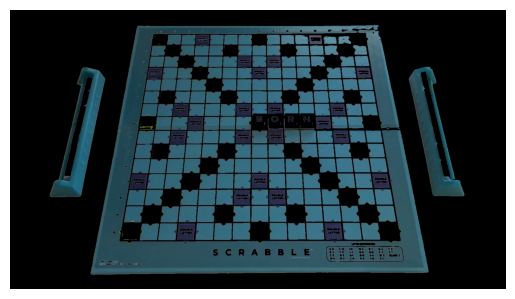

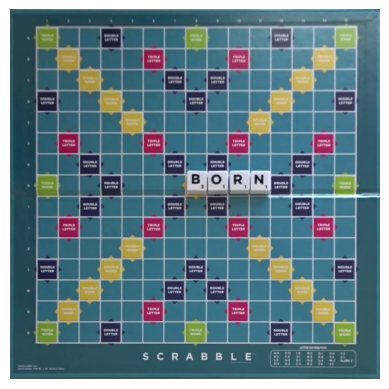

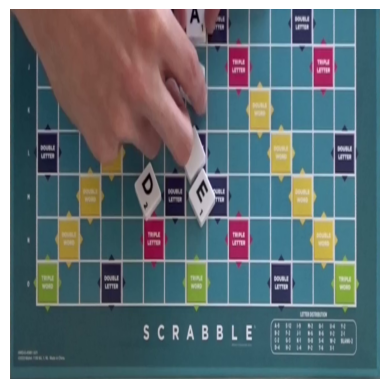

Pitch angle: 9.4 degrees!
Yaw angle: 0.0 degrees!


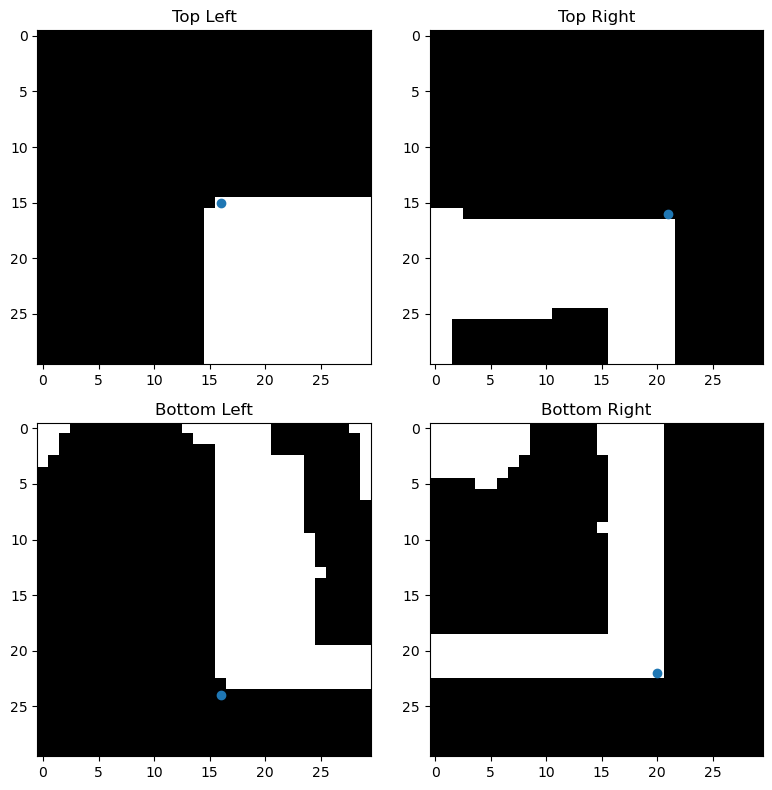

     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
   ---------------------------------------------
 1 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 2 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 3 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 4 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 5 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 6 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 7 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 8 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 9 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
10 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
11 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
12 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
13 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
14 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
15 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
   ---------------------------------------------
 1 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 2 | .  .  .  .  .  

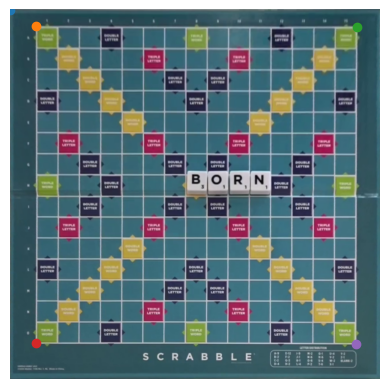

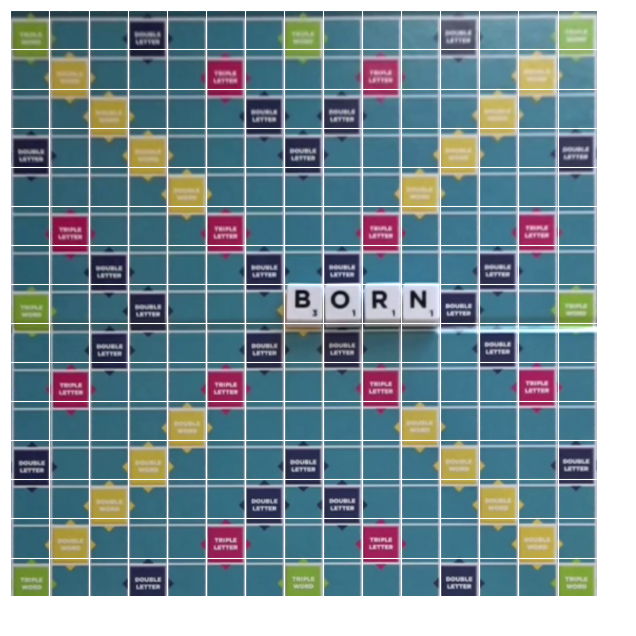

     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
   ---------------------------------------------
 1 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 2 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 3 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 4 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 5 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 6 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 7 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 8 | .  .  .  .  .  .  .  B  C  R  N  .  .  .  .
 9 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
10 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
11 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
12 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
13 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
14 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
15 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
   ---------------------------------------------
 1 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
 2 | .  .  .  .  .  

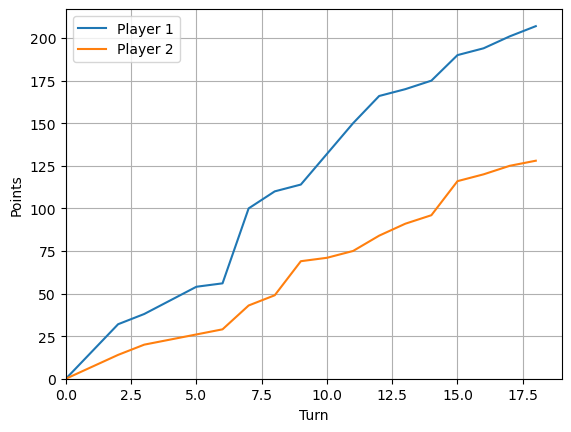

In [ ]:
# Get a frame every 20 seconds
frame_interval = 500
all_frames = get_frames("Scrabble Game.mp4", frame_interval)

# Get scrabble board data
all_im, all_im_filtered, hand_detected, all_warped, pitch_angle = get_scrabble_board(all_frames)

# Start game
reset_game()
p1_score = 0; p2_score = 0
all_p1_score = [p1_score]; all_p2_score = [p2_score]
turn = 1
prev_letter_grid = [["" for _ in range(15)] for _ in range(15)]

# Find corners of board
corners = find_board_corners(all_warped, hand_detected)

# Iterate through each 
for frame_chooser in range(len(all_warped)):

    # If there is no hand in the frame
    if not hand_detected[frame_chooser]:

        if frame_chooser == 2:
            # Plot corners over gray figure
            plt.figure()
            plt.imshow(img) 
            plt.scatter(0,0)
            plt.scatter(corners[0,0], corners[0,1])
            plt.scatter(corners[1,0], corners[1,1])
            plt.scatter(corners[2,0], corners[2,1])
            plt.scatter(corners[3,0], corners[3,1])
            plt.axis("off")
            plt.savefig('Corners.png', bbox_inches='tight', pad_inches=0)
            plt.show()

        # Get corners (will always be in same place) and warp board
        thickness_offset = np.array([0, int(-np.tan(pitch_angle)*50)])
        top_left_corner = corners[0,:] + thickness_offset
        top_right_corner = corners[1,:] + thickness_offset
        bottom_left_corner = corners[2,:] + thickness_offset
        bottom_right_corner = corners[3,:] + thickness_offset
        all_corners = np.array((top_left_corner, top_right_corner, bottom_left_corner, bottom_right_corner))
        img = all_warped[frame_chooser]
        warped_board2 = generate_warped_board2(img, all_corners)
        
        # Plot grid over board
        # Image size and grid dimensions
        board_size = 750
        num_squares = 15
        cell_size = board_size/num_squares

        # Generate coordinates for the grid lines
        x = np.linspace(0, board_size, num_squares + 1)
        y = np.linspace(0, board_size, num_squares + 1)
        X, Y = np.meshgrid(x, y)

        # Plot the warped board
        if frame_chooser == 2:
            plt.figure(figsize=(8, 8))
            plt.imshow(warped_board2)
            plt.axis("off")
            for i in range(num_squares + 1):
                plt.plot([x[i], x[i]], [0, board_size], color='white', linewidth=0.8)  # vertical
                plt.plot([0, board_size], [y[i], y[i]], color='white', linewidth=0.8)  # horizontal
            plt.axis("off")
            if frame_chooser == 2:
                plt.savefig('Cell Segmentation.png', bbox_inches='tight', pad_inches=0)
            plt.show()

        # Detect new letters and remove isolated misidentified letters 
        letter_grid = detect_letter(warped_board2, prev_letter_grid)
        letter_grid = remove_isolated_letters(letter_grid)

        # Print board state
        print_board(letter_grid)
        
        # Update the score if new word is formed
        if not np.array_equal(letter_grid, prev_letter_grid):
            prev_letter_grid = np.array(prev_letter_grid); letter_grid = np.array(letter_grid)
            p1_score, p2_score = update_score(p1_score, p2_score, prev_letter_grid, letter_grid, turn)
            turn += 1

            # Add to player's score depending on the turn
            if turn % 2 == 0:
                all_p1_score.append(p1_score)
            else:
                all_p2_score.append(p2_score)

        # New letter grid becomes previous letter grid
        prev_letter_grid = letter_grid

# Plot player scores over time
plt.figure()
plt.plot(all_p1_score)
plt.plot(all_p2_score)
plt.xlabel('Turn')
plt.ylabel('Points')
plt.xlim([0,int(turn/2 + 1)])
plt.ylim([0,10 + np.max(np.concatenate([all_p1_score, all_p2_score]))])
plt.legend(['Player 1', 'Player 2'])
plt.grid()
plt.savefig('Game Results.png')
plt.show()